# COMP0005 - GROUP COURSEWORK 2023-24
# Gesture Recognition via Convex Hull 

Use the cell below for all python code needed to realise the **Jarvis march algorithm** (including auxiliary data structures and functions needed by this algorithm - if any). The `jarvismarch()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points (`outputSet`) that lie on the convex hull.

In [444]:
import random
test_points = [(random.gauss(0, 1), random.gauss(0, 1)) for _ in range(100)]

In [445]:
# TODO: convex hull of 1 point is the point itself, convex hull of 2 points is also the points themselves

In [446]:
import math

# Utility functions

def is_counter_clockwise(p1: tuple[int, int], p2: tuple[int, int], p3: tuple[int, int]) -> bool:
    # vector product to check if p3 is to the left of the line p1 -> p2
    area = (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])
    return area > 0

def get_min_y_index(input_set: list[tuple[int, int]]) -> int:
    min_y = math.inf
    min_y_index = 0
    for i in range(len(input_set)):
        if input_set[i][1] < min_y:
            min_y = input_set[i][1]
            min_y_index = i
    return min_y_index

def distance(p1: tuple[int, int], p2: tuple[int, int]) -> int:
        return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

def sort_by_polar_angle(p0: tuple[int, int], input_set: list[tuple[int, int]]) -> list[tuple[int, int]]:
    input_set.sort(key=lambda p: math.atan2(p[1] - p0[1], p[0] - p0[0]))
    return input_set

def leftmost_point(points):
        # Return the point with the smallest x (and smallest y if necessary)
        return min(points)

In [447]:
def jarvis_march(input_set: list[tuple[int, int]]) -> list[tuple[int, int]]:
    """
    Returns the list of points that lie on the convex hull (jarvis march algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # Start with the leftmost point
    point_on_hull = leftmost_point(input_set)
    P = []  # Resulting convex hull
    i = 0

    while True:
        P.append(point_on_hull)
        # Start with the first point as the endpoint of the segment from point_on_hull
        endpoint = input_set[0]

        for j in range(0, len(input_set)):
            # Check against all other points
            if endpoint == point_on_hull or is_counter_clockwise(P[i], endpoint, input_set[j]):
                # Found a more counterclockwise point
                endpoint = input_set[j]

        i += 1  # Increment the index for the hull points list
        point_on_hull = endpoint

        # Check if we have wrapped around to the first point
        if endpoint == P[0]:
            break

    return P

Use the cell below for all python code needed to realise the **Graham scan** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `grahamscan()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [448]:
def graham_scan(input_set: list[tuple[int, int]]) -> list[tuple[int, int]]:
    """
    Returns the list of points that lie on the convex hull (graham scan algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    stack = []
    min_y_index = get_min_y_index(input_set)
    input_set[0], input_set[min_y_index] = input_set[min_y_index], input_set[0]
    p0 = input_set[0]
    sort_by_polar_angle(p0, input_set)
    stack.append(p0)
    stack.append(input_set[1])
    for i in range(2, len(input_set)):
        while len(stack) > 1 and not is_counter_clockwise(stack[-2], stack[-1], input_set[i]):
            stack.pop()
        stack.append(input_set[i])
    return stack

In [449]:
import matplotlib.pyplot as plt

def plot_points(input_set: list[tuple[int, int]], output_set: list[tuple[int, int]]) -> None:
    x = [i[0] for i in input_set]
    y = [i[1] for i in input_set]
    plt.scatter(x, y)
    x = [i[0] for i in output_set]
    y = [i[1] for i in output_set]
    # close the loop
    x.append(output_set[0][0])
    y.append(output_set[0][1])
    plt.plot(x, y)
    plt.show()

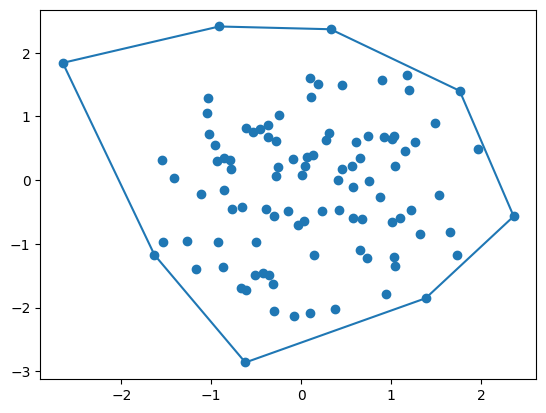

In [450]:
# test graham scan
output_set = graham_scan(test_points)
plot_points(test_points, output_set)

Use the cell below for all python code needed to realise the **Chen's** algorithm (including auxiliary data structures and functions needed by this algorithm - if any). The `chen()` function itself should take as input parameter a list of 2D points (`inputSet`), and return the subset of such points that lie on the convex hull (`outputSet`).

In [451]:
def partition_points(input_set: list[tuple[int, int]], num_partitions: int) -> list[list[tuple[int, int]]]:
    return [input_set[i::num_partitions] for i in range(num_partitions)]

def orientation(p: tuple[int, int], q: tuple[int, int], r: tuple[int, int]) -> int:
    # 0 -> colinear, 1 -> clockwise, -1 -> counterclockwise
    area = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if area == 0:
        return 0
    return 1 if area > 0 else -1

def find_tangent(p: tuple[int, int], hull: list[tuple[int, int]]) -> tuple[int, int]:
    n = len(hull)
    if n == 1:
        return hull[0]
    
    left = 0
    right = n - 1

    left_before = orientation(p, hull[0], hull[-1])
    left_after = orientation(p, hull[0], hull[(left + 1) % n])

    while left < right:
        mid = (left + right) // 2
        mid_before = orientation(p, hull[mid], hull[(mid - 1) % n])
        mid_after = orientation(p, hull[mid], hull[(mid + 1) % n])
        mid_side = orientation(p, hull[left], hull[mid])
        if mid_before != -1 and mid_after != -1:
            return hull[mid]
        elif (mid_side == 1 and (left_after == -1 or left_before == left_after)) \
                or (mid_side == -1 and mid_before == -1):
            right = mid
        else:
            left = mid + 1

        left_before = -mid_after
        left_after = orientation(p, hull[left], hull[(left + 1) % n])

    return hull[left]

def visualize_convex_hulls(
        partitions: list[tuple[int, int]],
        hulls: list[list[tuple[int, int]]], 
    ) -> None:

    for i in range(len(hulls)):
        x = [i[0] for i in partitions[i]]
        y = [i[1] for i in partitions[i]]
        plt.scatter(x, y)
        x = [i[0] for i in hulls[i]]
        y = [i[1] for i in hulls[i]]
        # close the loop
        x.append(hulls[i][0][0])
        y.append(hulls[i][0][1])
        plt.plot(x, y)
        
    plt.show()

def _chan(input_set: list[tuple[int, int]], h: int) -> list[tuple[int, int]] | None:
    """
    Returns the list of points that lie on the convex hull (chan's algorithm)
            Parameters:
                    input_set (list): a list of 2D points

            Returns:
                    output_set (list): a list of 2D points
    """
    # partition into h sets
    partitions = partition_points(input_set, h)
    
    # find convex hulls of each partition
    hulls = [graham_scan(partition) for partition in partitions]

    # visualize for debugging
    visualize_convex_hulls(partitions, hulls)

    # merge the convex hulls
    output_set = []
    
    p_0 = leftmost_point(input_set)
    output_set.append(p_0)

    for _ in range(h):
        max_point = None
        for i in range(len(hulls)):
            p = find_tangent(output_set[-1], hulls[i])
            # TODO: does this account for colinear points?
            if max_point is None or orientation(output_set[-1], p, max_point) > 0:
                max_point = p

        if max_point == p_0:
            return output_set
            
        output_set.append(max_point)
        
    return None

def chan(input_set: list[tuple[int, int]]) -> list[tuple[int, int]] | None:
    n = len(input_set)
    for t in range(2, len(input_set)):
        m = min(n, 2 ** 2 ** t)
        output_set = _chan(input_set, m)
        if output_set is not None:
            return output_set
        
    return None

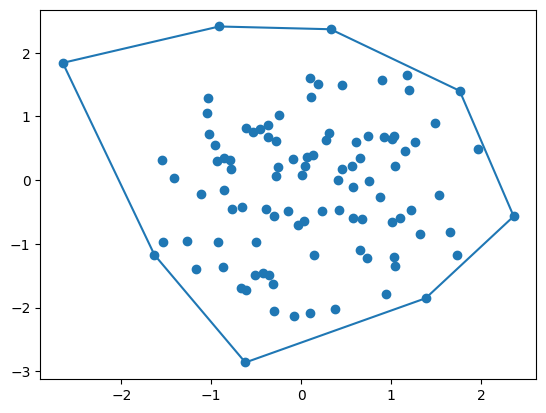

8


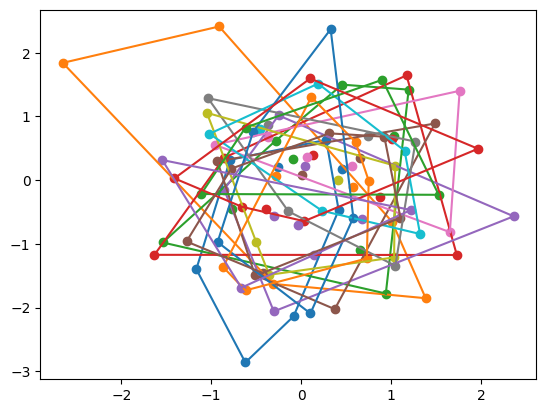

9


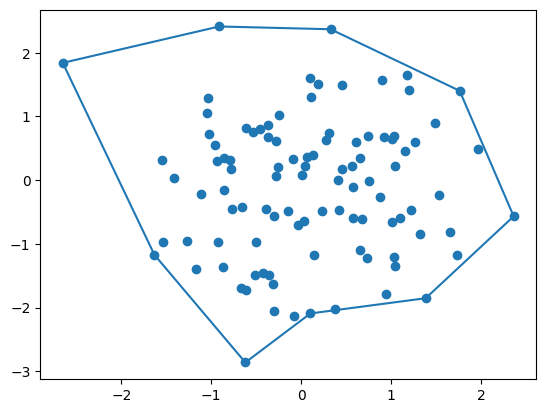

In [452]:
target_set = graham_scan(test_points)
plot_points(test_points, target_set)
print(len(target_set))
output_set = chan(test_points)
print(len(output_set))
plot_points(test_points, output_set)

Use the cell below to implement the **synthetic data generator** needed by your experimental framework (including any auxiliary data structures and functions you might need - be mindful of code readability and reusability).

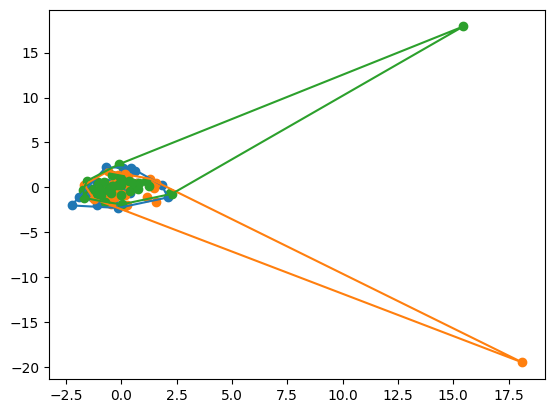

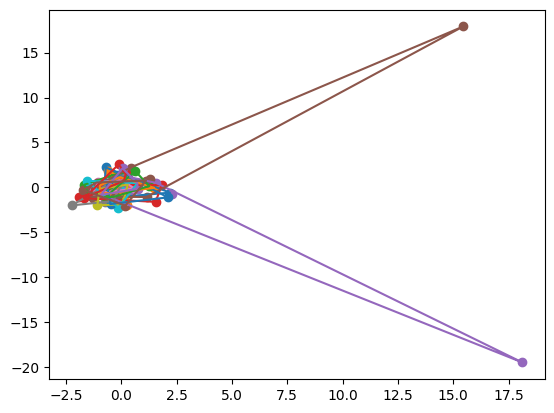

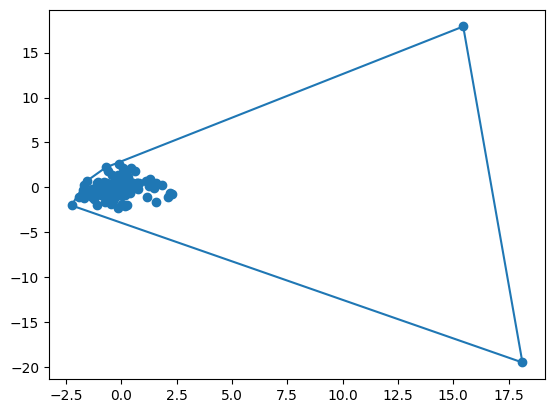

In [453]:
import random
import matplotlib.pyplot as plt


class TestDataGenerator():
    """
    A class to represent a synthetic data generator.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """

    def __init__():
        pass

    def generate_colinear_points():
        pass

    def generate_concentric_circles():
        pass

    def generate_random_points():
        pass

    #def generate_random_points_with_outliers():
    import random


# Define the function to generate random points with random outliers forming a triangle
    def generate_random_points_with_outliers(num_points=100):
        # Generate random points
        random_points = [(random.gauss(0, 1), random.gauss(0, 1)) for _ in range(num_points)]
        
        # Generate three random outlier points forming a triangle
        outliers = []
        for _ in range(2):
            outliers.append((random.uniform(-20, 20), random.uniform(-20, 20)))  # Random outliers within a larger range
            
        # Combine random points with outliers
        points_with_outliers = random_points + outliers
        
        return points_with_outliers


    # Function to plot points
    def plot_points(input_set, output_set):
        x = [i[0] for i in input_set]
        y = [i[1] for i in input_set]
        plt.scatter(x, y)
        x = [i[0] for i in output_set]
        y = [i[1] for i in output_set]
        # Close the loop
        x.append(output_set[0][0])
        y.append(output_set[0][1])
        plt.plot(x, y)
        plt.show()

    # Generate random points with outliers forming a triangle
    points_with_outliers = generate_random_points_with_outliers()

    # Partition the points into sets and visualize for debugging
    partitions = partition_points(points_with_outliers, 3)
    visualize_convex_hulls(partitions, [jarvis_march(partition) for partition in partitions])

    # Compute the convex hull using Chan's algorithm
    convex_hull = chan(points_with_outliers)

    # Plot the input points and the convex hull
    plot_points(points_with_outliers, convex_hull)




Use the cell below to implement the requested **experimental framework** API.

In [454]:
import timeit
import matplotlib

class ExperimentalFramework():
    """
    A class to represent an experimental framework.

    ...

    Attributes
    ----------
    
    [to be defined as part of the coursework]

    Methods
    -------
    
    [to be defined as part of the coursework]

    """
        
    #ADD YOUR CODE HERE
    
    def __init__():
        pass

Use the cell below to illustrate the python code you used to **fully evaluate** the three convex hull algortihms under considerations. The code below should illustrate, for example, how you made used of the **TestDataGenerator** class to generate test data of various size and properties; how you instatiated the **ExperimentalFramework** class to  evaluate each algorithm using such data, collect information about their execution time, plots results, etc. Any results you illustrate in the companion PDF report should have been generated using the code below.

In [455]:
# ADD YOUR TEST CODE HERE 



